# OHP Experience

## 1. Alpy

### 1.1 Setting

Import packages and collect files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import curve_fit
import scipy.ndimage as ndimage

''' 
My file for functions:
	- fastplot		Makes a simple plot
	- showfits		Prints fits image
	- targetDatafit		Extracts data from fits and print a row image
	- RotCor		Corrects the inclination of the spectrum, making a linear fit
More details are reported in the file itself: `functions.py` 
'''
import functions as my




folder_name = '26072022'

'''
In the file `targets.txt` the names of the fits data for the various targets. We took for each observation a lamp calibration.
	name	matrix with 3 columns:
				[0] name of fits file target 
				[1] calibration lamp fits 
				[2] flat (only for Jupiter) 
This is the index of rows:
	 [0]	Beta Lyr
	 [1]	Gamma Cyg
	 [2]	Jupiter		with flat
	 [3]	Moon White face	no calibration lamp
	 [4]	Moon Black face
	 [5]	Moon Black face only IMAGE
	 [6]	M57
	 [7]	Mars
	 [8]	Pi Cyg
	 [9]	Saturn
	[10]	Saturn only IMAGE
	[11]	Vega
	[12]	WR137
'''
names = pd.read_csv('./'+ folder_name +'/targets.csv',sep='\t')
names = pd.DataFrame(names).to_numpy() 
folders = ['betaLyr','gammaCygni','giove','luna','luna','luna','m57','marte','pyCygni','saturno','saturno','vega','wr137']
fold0 = 'C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/'	


ModuleNotFoundError: No module named 'functions'

### 1.2 Calibration

Take one object arbitrally and using the lines of the lamp NeAr in `calibration_lines.txt` fit the transmission function that converts px to lambda.

#### 1.2.1 First view at the target

I chose the target [0] and plot the spectrum in px

Filename: C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
Filename: C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   uint16   
1988
1988


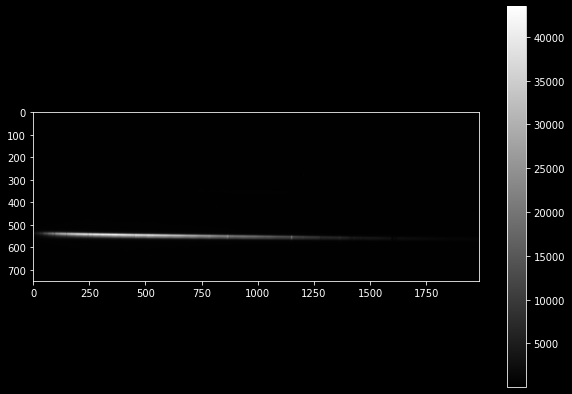

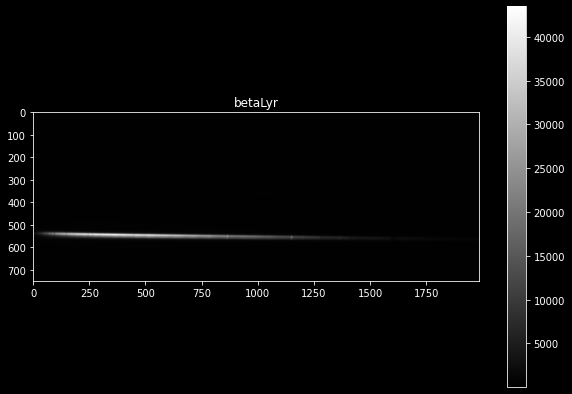

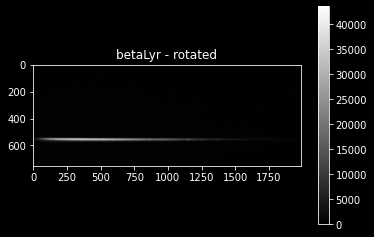

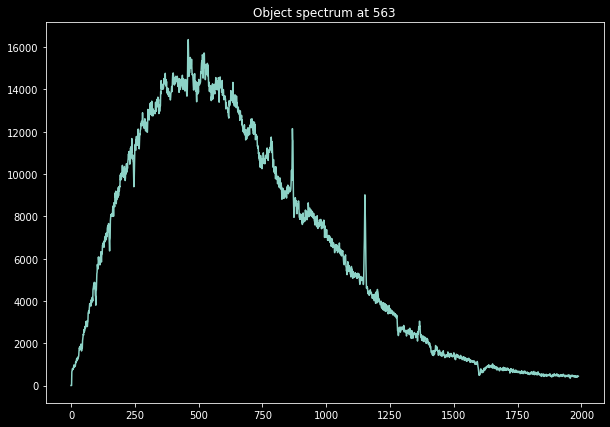

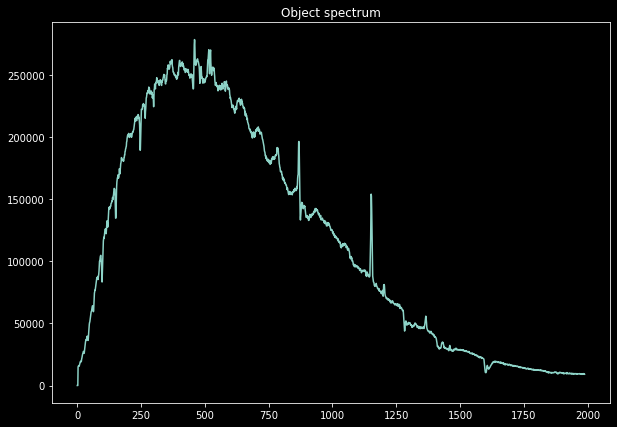

In [ ]:
obj_ind = 0

target_file = names[obj_ind][0]
calibration_file = names[obj_ind][1]
fold = fold0 + folders[obj_ind]+'/'

# function to open fits
path = lambda name : fold + name + '.fit'

# Set the cut
ly,ry = [650,1400]
lx,rx = [760,-1]

## Open target image
# data[Y,X]
hdul, data = my.targetDatafit(path(target_file),lims=[ly,ry,lx,rx],hotpx=True)
nx = len(data[0,:]); ny = len(data[:,0])

hdul[0].header['OBJECT'] = 'Beta Lyr'
hdul.info()

print(nx)


# Spectrum image
my.showfits(data,folders[obj_ind])



# rotation correction
# rotate the image
angle, data_rot = my.RotCor(data)

# plot
plt.figure()
plt.title(folders[obj_ind]+' - rotated')
plt.imshow(data_rot, cmap='gray')
plt.colorbar()

# spectrum graph
data = data_rot
cut = 563
values = data[cut,:]
nx = len(data[0,:]); ny = len(data[:,0])
print(nx)

# remove noise
# values -= data[350,:]

# plot at cut
my.fastplot(np.linspace(0,nx,nx),values,title=f'Object spectrum at {cut}')

# sum in a range of the spectrum
values = np.array([data[555:574,j].sum() for j in range(nx) ])

# remove noise
# values -= data[350,:]

# plot
my.fastplot(np.linspace(0,nx,nx),values,title='Object spectrum')

plt.show()


hdul.close()

#### 1.2.2 Calibrate the lamp

Make a fit for the lines with a polynom of 3rd order and plot the spectrum of the obj in lambda.

Then make a table with the lines.

Filename: C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/betaLyr/betaLyr_alpy_lamp_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
1988 1988


C:\Users\berna\AppData\Local\Temp/ipykernel_9644/527033520.py:58: RuntimeWarning: invalid value encountered in sqrt
  error = np.array([np.sqrt((pcov[i,:]).sum()) for i in range(4)])


[ 3.68454323e+03  2.54216802e+00 -1.14929184e-05 -3.29918443e-08] [11.53302683         nan  0.01944174         nan]


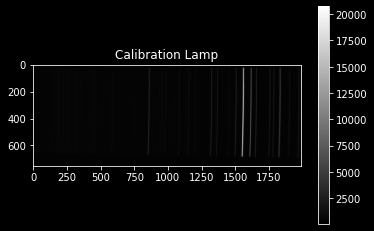

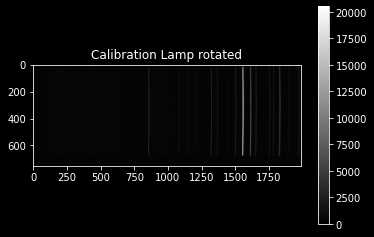

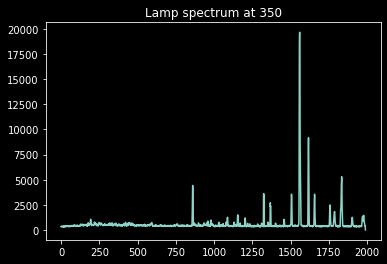

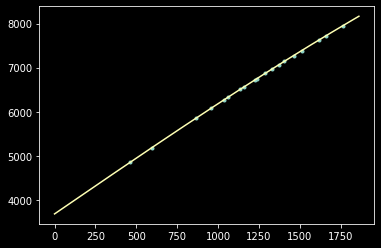

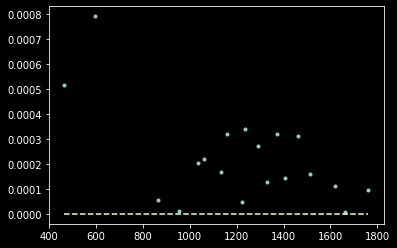

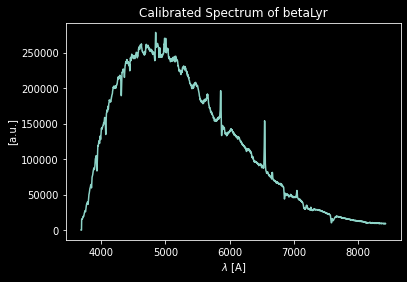

<class 'numpy.ndarray'>
<class 'function'>


In [ ]:
# Open calibraion file
hdul = fits.open(path(calibration_file))

hdul.info()

# data[Y,X]
cdata = hdul[0].data
cdata = cdata[ly:ry,lx:rx]
cnx = len(cdata[0,:]); cny = len(cdata[:,0])

print(nx,cnx)
cdata_rot = ndimage.rotate(cdata, angle, reshape=False)


# Spectrum image
plt.figure()
plt.title('Calibration Lamp')
plt.imshow(cdata, cmap='gray')
plt.colorbar()

plt.figure()
plt.title('Calibration Lamp rotated')
plt.imshow(cdata_rot, cmap='gray')
plt.colorbar()


# spectrum graph
cdata = cdata_rot
cut = 350
cvalues = cdata[cut,:]
cnx = len(cdata[0,:]); cny = len(cdata[:,0])


plt.figure()
plt.title(f'Lamp spectrum at {cut}')
plt.plot(np.linspace(0,cnx,cnx),cvalues)



## Fit
lA, lpx = np.loadtxt(fold+'calibration_lines.txt',unpack=True)

def FitFun(x,p0,p1,p2,p3):
	return p0 + p1*x + p2*x**2 + p3*x**3

initial_values = np.array([1e2,1e1,1.,0.])
pop, pcov = curve_fit(FitFun,lpx,lA,initial_values)
p1,p2,p3,p4 = pop
Dp1,Dp2,Dp3,Dp4 = np.sqrt(pcov.diagonal())

for i in range(2):
	initial_values = pop
	pop, pcov = curve_fit(FitFun,lpx,lA,initial_values)
	p1,p2,p3,p4 = pop
	Dp1,Dp2,Dp3,Dp4 = np.sqrt(pcov.diagonal())


error = np.array([np.sqrt((pcov[i,:]).sum()) for i in range(4)])
print(pop,error)

plt.figure()
xx = np.linspace(0,max(lpx)+100,1000)
plt.plot(lpx,lA,'.')
plt.plot(xx,FitFun(xx,p1,p2,p3,p4))

plt.figure()
plt.plot(lpx,abs(1-FitFun(lpx,p1,p2,p3,p4)/lA),'.')
plt.plot([min(lpx),max(lpx)],[0,0],'--')

##! True target spectrum
px = np.linspace(0,nx,nx)
l = FitFun(px,p1,p2,p3,p4)

plt.figure()
plt.title('Calibrated Spectrum of ' + folders[obj_ind])
plt.xlabel('$\lambda$ [A]'); plt.ylabel('[a.u.]')
plt.plot(l,values)

plt.show()

print(type(px))
print(type(FitFun))
hdul.close()


#### 1.2.3 Flat

Open the flat and Jupiter files, adjust rotation and take the normalized flat.

Then plot the corrected spectrum.

Filename: C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/giove/giove_flat_alpy_26072022.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
Filename: C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/giove/giove_alpy_26072022_0116.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
1988
1988
0.6810687149950692 1.2444388492436464
1988 1988 1988


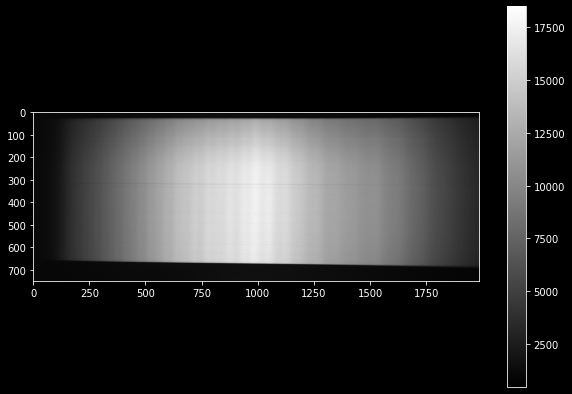

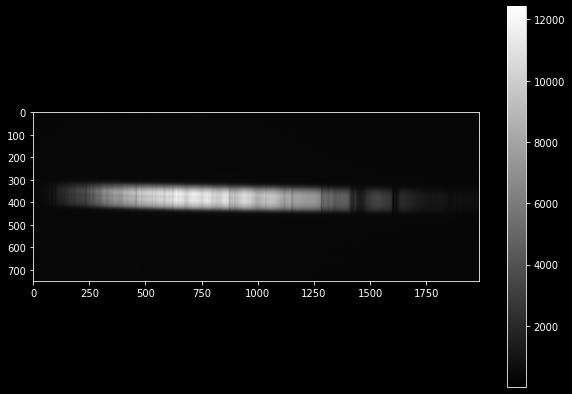

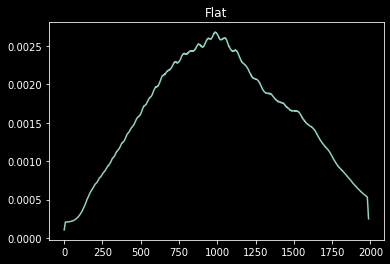

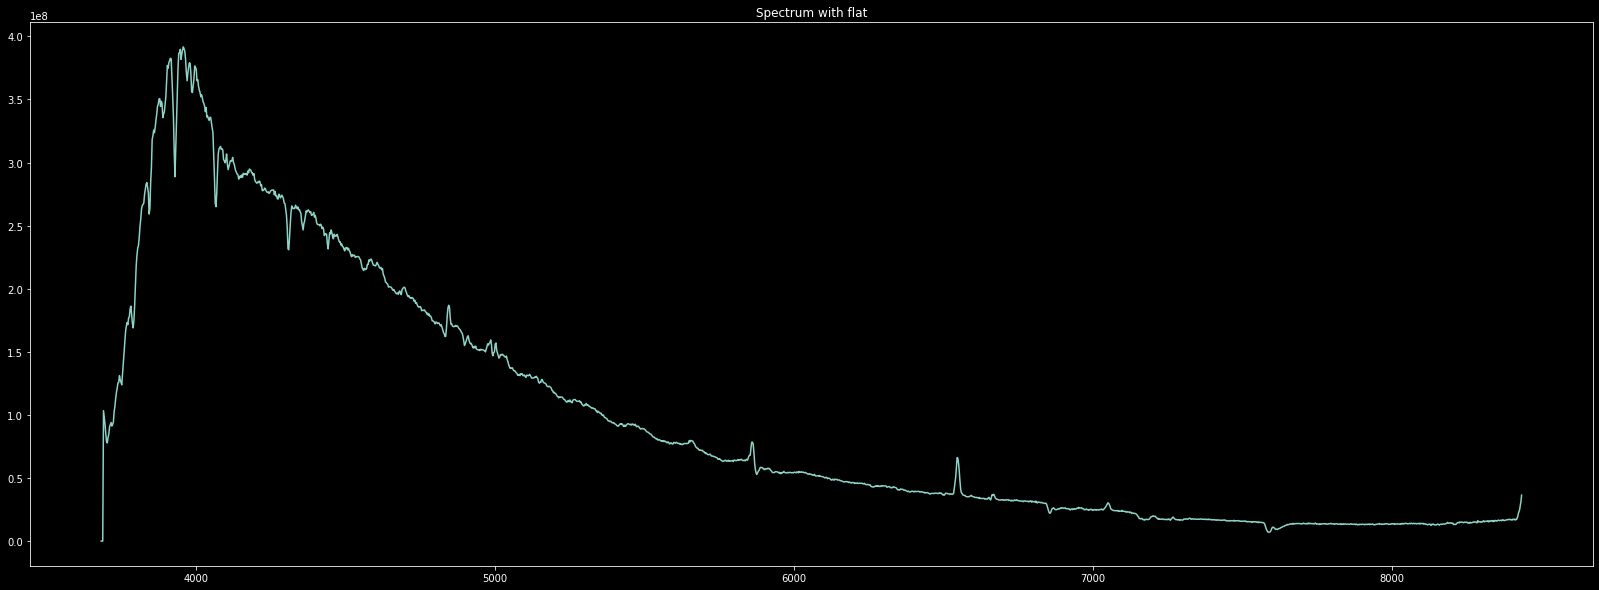

In [ ]:
hdulFlat, dataFlat = my.targetDatafit(fold0+'giove/'+names[2][2]+'.fit',lims=[ly,ry,lx,rx])
hdulJup, dataJup   = my.targetDatafit(fold0+'giove/'+names[2][0]+'.fit',lims=[ly,ry,lx,rx])

print(len(dataFlat[0,:]))
angleJup, dataJup = my.RotCor(dataJup)
dataFlat = ndimage.rotate(dataFlat,angleJup,reshape=False)
print(len(dataFlat[0,:]))


nxf = len(dataFlat[0,:]); nyf = len(dataFlat[:,0])

print(angle,angleJup)
print(nx,cnx,nxf)



valuesFlat = np.array([dataFlat[:,j].sum() for j in range(nxf)])

flat = dataFlat.sum()

# Flat
flat = valuesFlat/flat

plt.figure()
plt.title('Flat')
plt.plot(np.linspace(0,nxf,nxf),flat)

plt.figure(figsize=[28,10])
plt.title('Spectrum with flat')
plt.plot(l,values/flat)

plt.show()

### 1.3 Correlation

Now choose another target and maximize the convolution between the previous lamp spectrum and the this one to get the shift of the picks.

Filename: C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/vega/vega_alby_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
Filename: C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/vega/vega_alby_lamp_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1.4263315393617606


C:\Users\berna\AppData\Local\Temp/ipykernel_9644/4082646484.py:38: RuntimeWarning: overflow encountered in ulong_scalars
  corr = correlate(stdLamp,values2)/np.sqrt((values2**2).sum()*(stdLamp**2).sum())#nx2


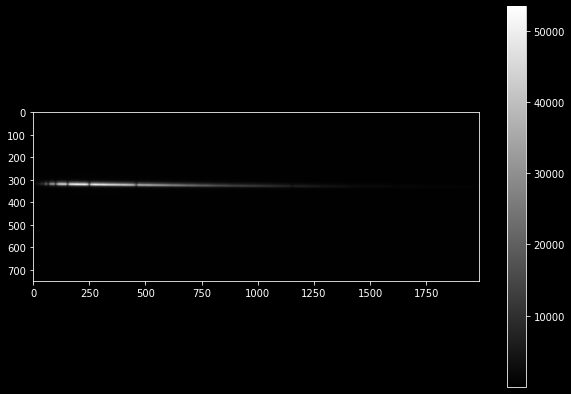

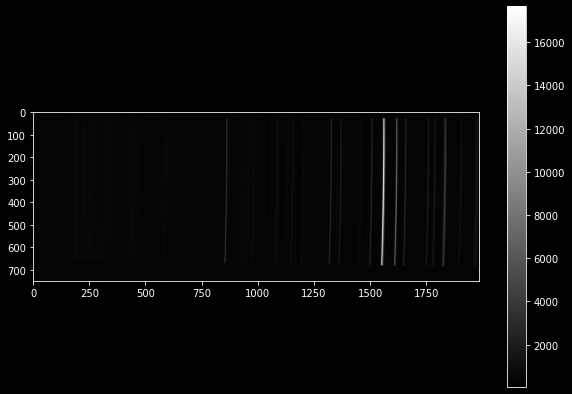

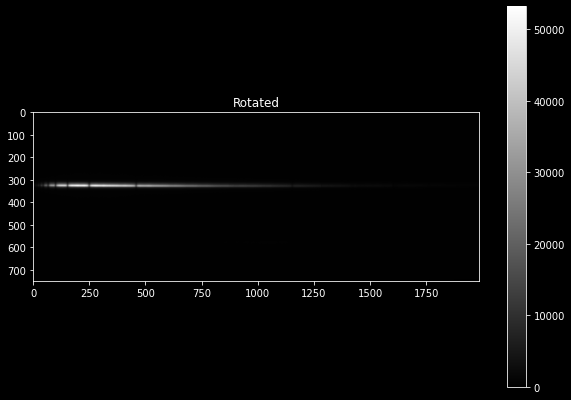

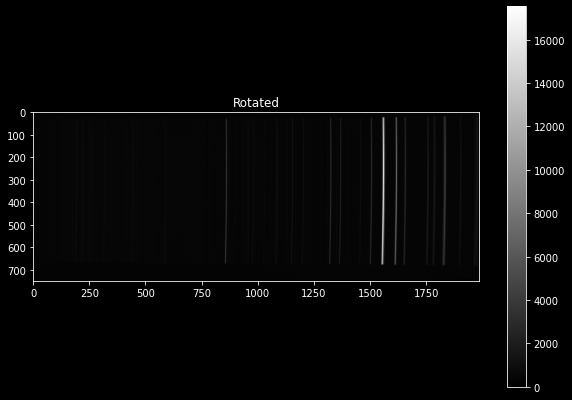

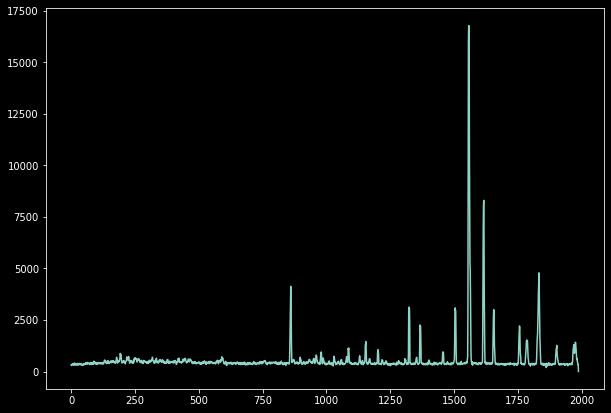

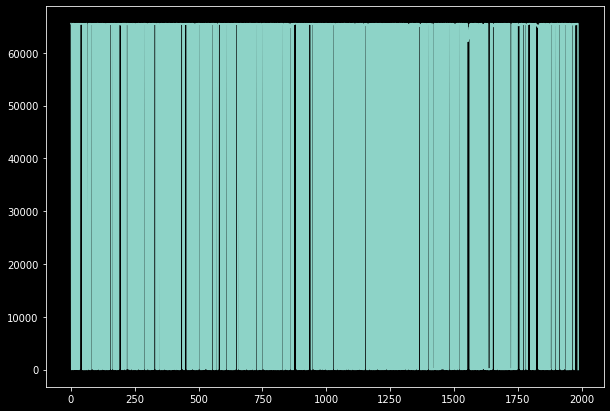

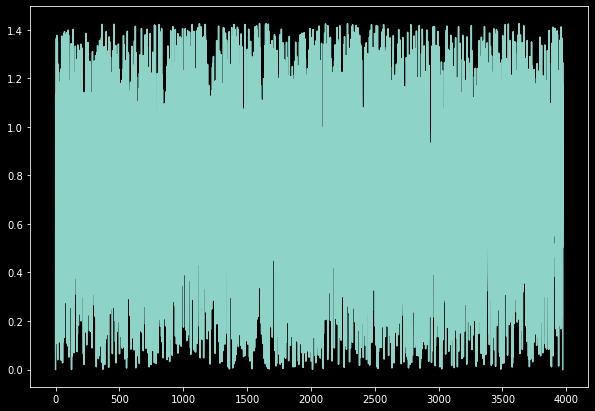

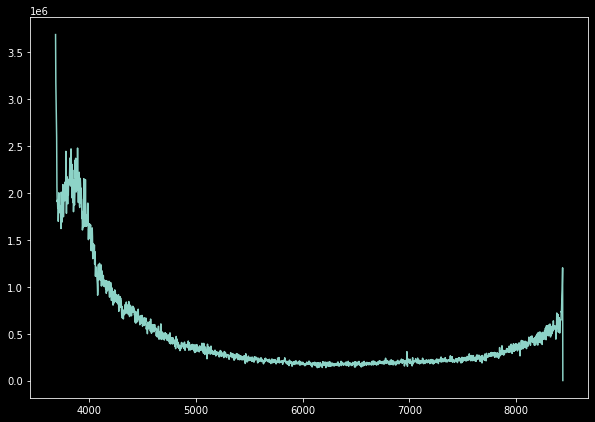

In [ ]:
from scipy.signal import correlate

obj_ind = 11

target_file = names[obj_ind][0]
calibration_file = names[obj_ind][1]
fold = fold0 + folders[obj_ind]+'/'

# function to open fits
path = lambda name : fold + name + '.fit'

hdul1,data1 = my.targetDatafit(path(target_file),lims=[ly,ry,lx,rx])
hdul2,data2 = my.targetDatafit(path(calibration_file),lims=[ly,ry,lx,rx])

print(type(data))

angle, data1 = my.RotCor(data1)
data2 =  ndimage.rotate(data2, angle, reshape=False)

my.showfits(data1,title='Rotated')
my.showfits(data2,title='Rotated')


## Correlation
# set the fit lamp values as a standard
stdLamp = cvalues
stdnx   = len(stdLamp)

values2 = data2[cut,:]
nx2 = len(values2)

print(type(values2))

my.fastplot(range(nx2),values2)
my.fastplot(range(nx2),values2-stdLamp)


corr = correlate(stdLamp,values2)/np.sqrt((values2**2).sum()*(stdLamp**2).sum())#nx2
print(max(corr))
my.fastplot(range(len(corr)),corr)

corr = max(corr)
tmppos = lambda x : np.where(x == max(x))

x = np.linspace(0,nx2,nx2)
if( tmppos(values2)[0]-tmppos(stdLamp)[0]>0 ):
	x -= corr
else:
	x += corr

l2 = FitFun(x,p1,p2,p3,p4)

my.fastplot(l2,data1[cut,:]/flat)

plt.show()